In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and draw a graph
def generate_graph(num_nodes=3, num_edges=3, edges=None, random=False, highlight_edges=None):
    G = nx.Graph()
    if random:
        G = nx.gnm_random_graph(num_nodes, num_edges)
        edges = list(G.edges())
    else:
        if edges is None:
            raise ValueError("Edges must be provided if not generating a random graph")
        if min(min(edges)) == 1:
            edges = [(u - 1, v - 1) for u, v in edges]  # Convert 1-based to 0-based
        G.add_edges_from(edges)
        nodes = set()
        for edge in edges:
            nodes.update(edge)
        num_nodes = len(nodes)
    
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="grey")
    if highlight_edges:
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, edge_color='red', width=2)
    # plt.savefig(f"./graph/{var}.jpg")
    plt.show()
    # nx.write_gml(G, f"./graph/gml_{var}.gml")
    
    return G, num_nodes, edges


def node_color_to_index(node, color, k):
    index = (node) * k + (color - 1)
    return index

def create_Qmatrix(k, G, QUBO_panaliy):
    num_nodes = len(G.nodes)
    edges = list(G.edges)
    
    matrix_size = num_nodes * k
    Qmatrix = np.zeros((matrix_size, matrix_size))

    QUBO_panaliy = 4  # Penalty

    for i in range(num_nodes):
        submatrix = Qmatrix[i*k:(i+1)*k, i*k:(i+1)*k]
        for row in range(k):
            for col in range(k):
                if row == col:
                    submatrix[row, col] = -QUBO_panaliy
                else:
                    submatrix[row, col] = QUBO_panaliy
    for edge in edges:
        node1, node2 = edge
        for color in range(1, k + 1):
            index1 = node_color_to_index(node1, color, k)
            index2 = node_color_to_index(node2, color, k)
            Qmatrix[index1, index2] = QUBO_panaliy / 2
            Qmatrix[index2, index1] = QUBO_panaliy / 2

    return Qmatrix

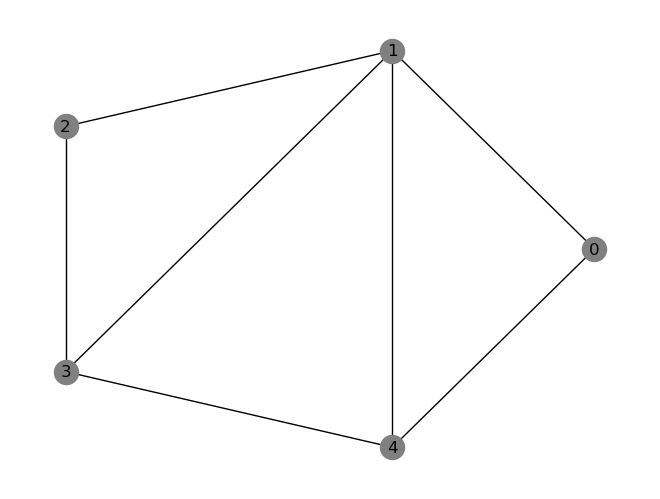

[[-4.  4.  4.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 4. -4.  4.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.]
 [ 4.  4. -4.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 2.  0.  0. -4.  4.  4.  2.  0.  0.  2.  0.  0.  2.  0.  0.]
 [ 0.  2.  0.  4. -4.  4.  0.  2.  0.  0.  2.  0.  0.  2.  0.]
 [ 0.  0.  2.  4.  4. -4.  0.  0.  2.  0.  0.  2.  0.  0.  2.]
 [ 0.  0.  0.  2.  0.  0. -4.  4.  4.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  4. -4.  4.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  4.  4. -4.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  2.  0.  0. -4.  4.  4.  2.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  2.  0.  4. -4.  4.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.  2.  4.  4. -4.  0.  0.  2.]
 [ 2.  0.  0.  2.  0.  0.  0.  0.  0.  2.  0.  0. -4.  4.  4.]
 [ 0.  2.  0.  0.  2.  0.  0.  0.  0.  0.  2.  0.  4. -4.  4.]
 [ 0.  0.  2.  0.  0.  2.  0.  0.  0.  0.  0.  2.  4.  4. -4.]]


In [2]:
# Fixed Graph
example_edges = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (5, 2), (2, 4)]
G, num_nodes, edges = generate_graph(edges=example_edges)

# Random Graph
# num_nodes = 6
# G, num_nodes, edges = generate_graph(num_nodes, 6, random=True)
k = 3
p = 4
Qmatrix = create_Qmatrix(k, G, p)
print(Qmatrix)

In [3]:
from qiskit.quantum_info import SparsePauliOp

def build_qubo_paulis(Q: np.ndarray) -> list[tuple[str, float]]:
    """Convert a QUBO matrix to a list of Pauli operators."""
    n = Q.shape[0]
    pauli_list = []
    for i in range(n):
        for j in range(i, n):
            if Q[i, j] != 0:
                paulis = ["I"] * n
                if i == j:
                    paulis[i] = "Z"
                else:
                    paulis[i] = "Z"
                    paulis[j] = "Z"
                pauli_list.append(("".join(paulis)[::-1], Q[i, j]))
    return pauli_list

qubo_paulis = build_qubo_paulis(Qmatrix)
cost_hamiltonian = SparsePauliOp.from_list(qubo_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)


Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIZIZ', 'IIIIIIIIIIIZIIZ', 'IIZIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZI', 'IIIIIIIIIIZIIZI', 'IZIIIIIIIIIIIZI', 'IIIIIIIIIIIIZII', 'IIIIIIIIIZIIZII', 'ZIIIIIIIIIIIZII', 'IIIIIIIIIIIZIII', 'IIIIIIIIIIZZIII', 'IIIIIIIIIZIZIII', 'IIIIIIIIZIIZIII', 'IIIIIZIIIIIZIII', 'IIZIIIIIIIIZIII', 'IIIIIIIIIIZIIII', 'IIIIIIIIIZZIIII', 'IIIIIIIZIIZIIII', 'IIIIZIIIIIZIIII', 'IZIIIIIIIIZIIII', 'IIIIIIIIIZIIIII', 'IIIIIIZIIZIIIII', 'IIIZIIIIIZIIIII', 'ZIIIIIIIIZIIIII', 'IIIIIIIIZIIIIII', 'IIIIIIIZZIIIIII', 'IIIIIIZIZIIIIII', 'IIIIIZIIZIIIIII', 'IIIIIIIZIIIIIII', 'IIIIIIZZIIIIIII', 'IIIIZIIZIIIIIII', 'IIIIIIZIIIIIIII', 'IIIZIIZIIIIIIII', 'IIIIIZIIIIIIIII', 'IIIIZZIIIIIIIII', 'IIIZIZIIIIIIIII', 'IIZIIZIIIIIIIII', 'IIIIZIIIIIIIIII', 'IIIZZIIIIIIIIII', 'IZIIZIIIIIIIIII', 'IIIZIIIIIIIIIII', 'ZIIZIIIIIIIIIII', 'IIZIIIIIIIIIIII', 'IZZIIIIIIIIIIII', 'ZIZIIIIIIIIIIII', 'IZIIIIIIIIIIIII', 'ZZIIIIIIIIIIIII', 'ZIIIIII

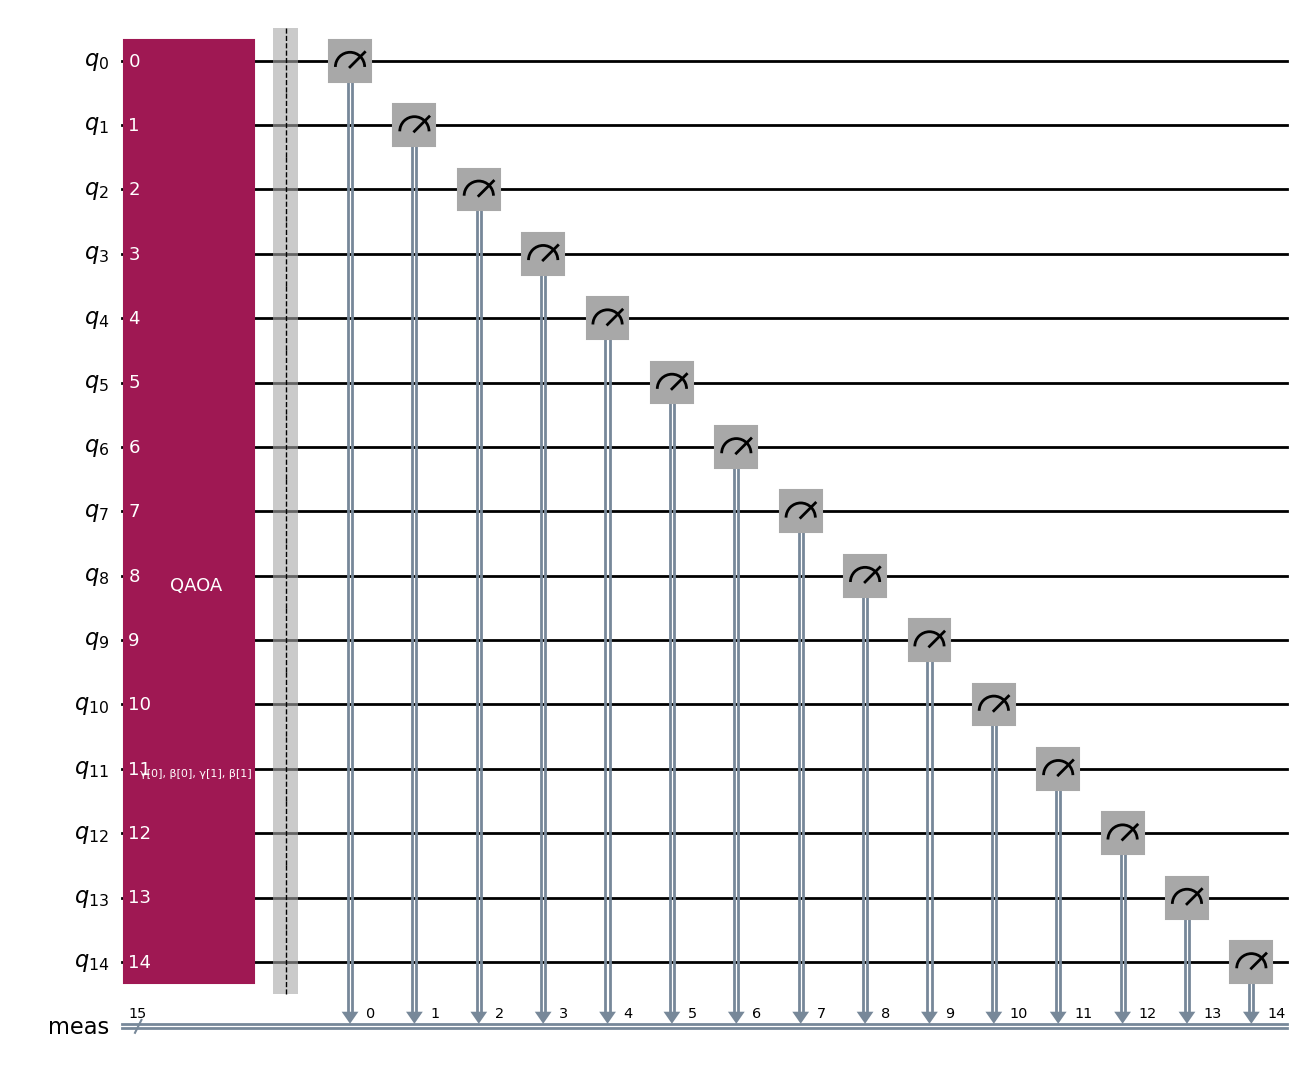

In [4]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

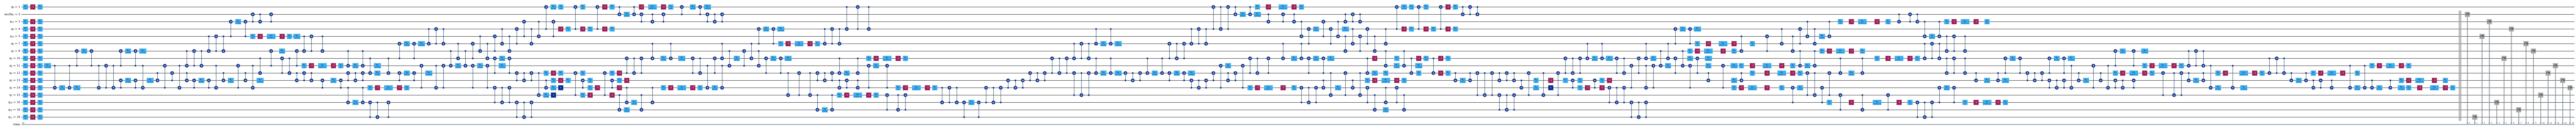

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeAuckland, FakeWashingtonV2

# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False)
backend = FakeAuckland()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [6]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [7]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [8]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

c:\Users\junji\.conda\envs\MQC\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:338: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\junji\.conda\envs\MQC\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:338: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\junji\.conda\envs\MQC\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:338: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -18.57542457542457
       x: [ 4.113e+00  2.592e+00  3.097e+00  1.594e+00]
    nfev: 31
   maxcv: 0.0


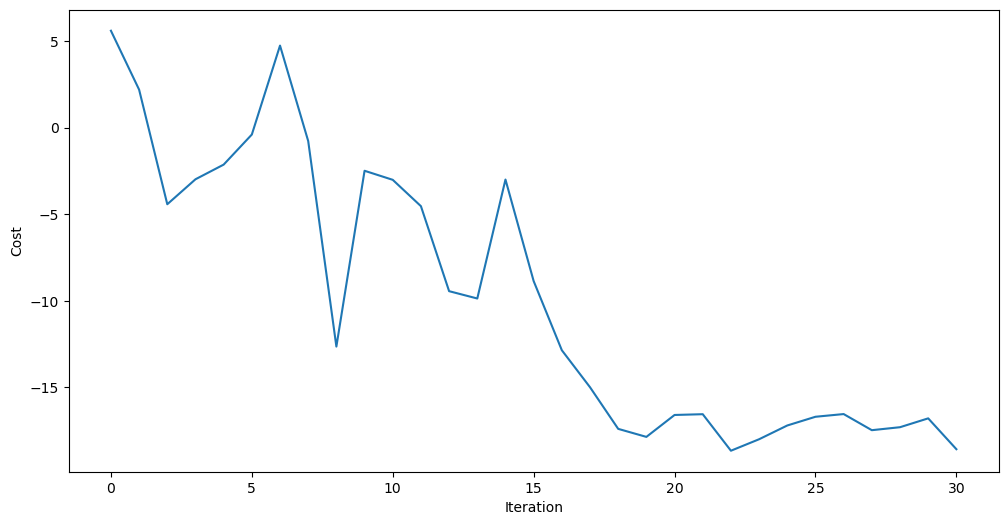

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

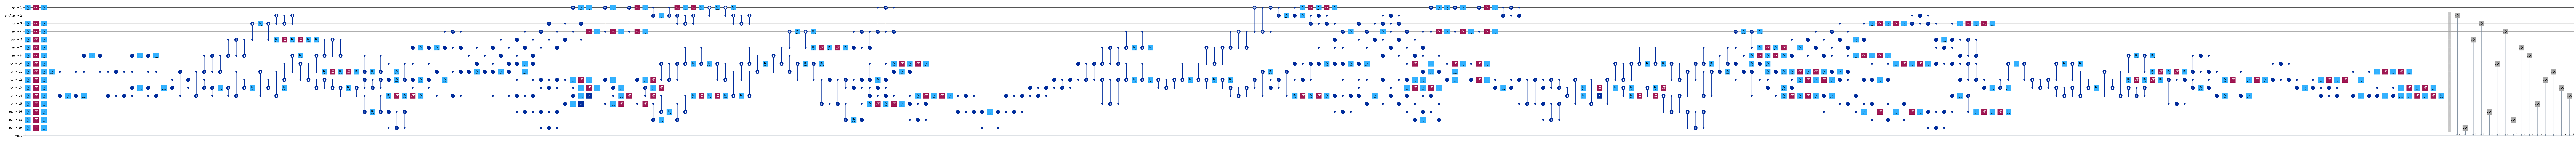

In [10]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

c:\Users\junji\.conda\envs\MQC\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:338: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


{12985: 0.0001, 14460: 0.0001, 27776: 0.0001, 23256: 0.0001, 26860: 0.0002, 6429: 0.0002, 27660: 0.0001, 25876: 0.0001, 19683: 0.0001, 17162: 0.0002, 17689: 0.0004, 23636: 0.0002, 17681: 0.0002, 5440: 0.0002, 4835: 0.0001, 30747: 0.0001, 24994: 0.0001, 17486: 0.0001, 14156: 0.0001, 27100: 0.0001, 19453: 0.0001, 1816: 0.0001, 6755: 0.0001, 25101: 0.0002, 6995: 0.0001, 20140: 0.0001, 7180: 0.0002, 17169: 0.0008, 22666: 0.0002, 17172: 0.0003, 17058: 0.0005, 1600: 0.0001, 4739: 0.0001, 20136: 0.0001, 789: 0.0001, 11563: 0.0001, 26961: 0.0004, 14417: 0.0002, 21913: 0.0001, 11394: 0.0001, 17922: 0.0002, 11314: 0.0001, 18688: 0.0001, 25546: 0.0001, 23714: 0.0002, 20661: 0.0001, 6340: 0.0001, 18731: 0.0001, 25272: 0.0001, 20041: 0.0002, 9948: 0.0001, 3189: 0.0001, 31817: 0.0001, 6010: 0.0001, 8993: 0.0004, 6420: 0.0005, 2228: 0.0002, 6320: 0.0002, 30722: 0.0001, 25196: 0.0002, 22722: 0.0001, 5769: 0.0002, 4802: 0.0001, 16611: 0.0002, 31507: 0.0001, 16935: 0.0001, 6819: 0.0001, 6091: 0.0001, 29

In [12]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_nodes*k)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]


In [13]:
sorted_distribution = sorted(final_distribution_int.items(), key=lambda item: item[1], reverse=True)

# Extract the top 10 keys
top_10_keys = [item[0] for item in sorted_distribution[:10]]

# Convert the top 10 keys to 15-bit bitstrings and reverse them
top_10_bitstrings = [to_bitstring(key, 15)[::-1] for key in top_10_keys]

# Print the top 10 keys and their bitstring representations
print("Top 10 keys with highest values and their bitstring representations:")
for key, bitstring in zip(top_10_keys, top_10_bitstrings):
    print(f"Key: {key}, Bitstring: {bitstring}")

Top 10 keys with highest values and their bitstring representations:
Key: 17169, Bitstring: [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Key: 5220, Bitstring: [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Key: 17025, Bitstring: [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Key: 17676, Bitstring: [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Key: 8961, Bitstring: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
Key: 18521, Bitstring: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Key: 5204, Bitstring: [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Key: 4770, Bitstring: [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
Key: 17500, Bitstring: [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Key: 18482, Bitstring: [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]


In [14]:
# Verification

def solution_to_color_dict(solution, num_nodes, k):
    color_dict = {}
    for node in range(num_nodes):
        for color in range(k):
            if solution[node * k + color] == 1:
                color_dict[node] = color + 1
                break

    print("Coloring dictionary:",color_dict)
    return color_dict

def valid_results(num_nodes, k, graph, coloring):
    if len(coloring) < num_nodes: #The node with all 0s in its corresponding qpu solution is missing in the result color dictionary, which needs to be assigned an extra color.
        print("Because of result error, one extra color will be added. k =", k+1)
        coloring = check_and_fill_missing_nodes(num_nodes, coloring, k+1)
    is_valid = validate_graph_coloring(graph, coloring)
    print("Is coloring valid? -", is_valid)
    is_minimum_coloring(graph, coloring)

def check_and_fill_missing_nodes(num_nodes, color_dict, fill_color):
    
    for key in range(num_nodes):
        if key not in color_dict:
            color_dict[key] = fill_color
            print("Error in:", key)
        
    return color_dict

def validate_graph_coloring(graph, coloring):
    for u, v in graph.edges():
        if coloring[u] == coloring[v]:
            return False  
        
        return True 


def get_approx_chromatic_number(graph):
    coloring = nx.greedy_color(graph, strategy="largest_first")
    used_colors = set(coloring.values())
    return len(used_colors)

def is_minimum_coloring(graph, coloring):
    approx_chromatic_number = get_approx_chromatic_number(graph)
    used_colors = set(coloring.values())
    if len(used_colors) == approx_chromatic_number:
        print("Is the coloring using minimum number of colors? -", True)
    else:
        print("Is the coloring using minimum number of colors? -", False)
        print("Minimum number of colors(approx_chromatic_number):", approx_chromatic_number, "Number of colors used:", len(used_colors))


In [17]:
color_dict = solution_to_color_dict(list(top_10_bitstrings[0]), num_nodes, 3)
valid_results(num_nodes, k, G, color_dict)

Coloring dictionary: {0: 1, 1: 2, 2: 3, 3: 1, 4: 3}
Is coloring valid? - True
Is the coloring using minimum number of colors? - True
